**Proyecto de Ciencia de Datos**

Emplearemos datos del censo de California para poder predecir el precio medio de la vivienda en cualquier distrito. Cada observación representa un distrito que está caracterizado por métricas como la población, el ingreso medio y el precio medio de la vivienda, etc.

Diccionario de la base de datos Housing


- longitude: La longitud geográfica de la vivienda.
- latitude: La latitud geográfica de la vivienda.
- housing_median_age: La mediana de la edad de las viviendas en la zona, en años.
- total_rooms: El número total de habitaciones en la vivienda.
- total_bedrooms: El número total de dormitorios en la vivienda.
- population: La población total en la zona de la vivienda.
- households: El número total de hogares en la zona de la vivienda.
- median_income: El ingreso mediano de los hogares en la zona de la vivienda, en decenas de miles de dólares.
- median_house_value: La mediana del valor de las casas en la zona, en dólares.
- ocean_proximity: La proximidad de la vivienda al océano (ej., 'NEAR BAY' indica cercanía a la bahía).

Variable target

Este campo representa el valor mediano de las casas en la zona, expresado en dólares. Es el valor que modelos de aprendizaje automático intentarían predecir, basándose en las otras características disponibles en el dataset.

# 01 Importación de librerías






In [49]:
import numpy as np
import os

import sklearn
assert sklearn.__version__ >= "0.20"

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import os
import tarfile
import urllib.request
from pandas.plotting import scatter_matrix


# 02 Configuración para almacenamiento de figuras

In [26]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 03 Obtención del dataset



## 03_1  Importación del dataset











In [27]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

In [28]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
### def: utilizado para crear o definir una función

housing = load_housing_data()

In [29]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


## 03_2  Estructura de datos

In [30]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [31]:
housing.shape

(20640, 10)

Revisamos algunas variables.

In [32]:
housing['median_income']

0        8.3252
1        8.3014
2        7.2574
3        5.6431
4        3.8462
          ...  
20635    1.5603
20636    2.5568
20637    1.7000
20638    1.8672
20639    2.3886
Name: median_income, Length: 20640, dtype: float64

In [33]:
housing['ocean_proximity']

0        NEAR BAY
1        NEAR BAY
2        NEAR BAY
3        NEAR BAY
4        NEAR BAY
           ...   
20635      INLAND
20636      INLAND
20637      INLAND
20638      INLAND
20639      INLAND
Name: ocean_proximity, Length: 20640, dtype: object

In [34]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Descripción de las categorías:
- <1H OCEAN: Viviendas ubicadas a menos de una hora del océano.
- INLAND: Viviendas situadas en el interior, lejos del océano.
- NEAR OCEAN: Viviendas cercanas al océano, generalmente a poca distancia.
- NEAR BAY: Viviendas próximas a una bahía, con acceso y vistas al agua cercanas.
- ISLAND: Viviendas situadas en islas, raras y potencialmente de alto valor.







## 03_3 Estadísticas descriptivas

In [35]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## 03_4  Visualización

Saving figure attribute_histogram_plots


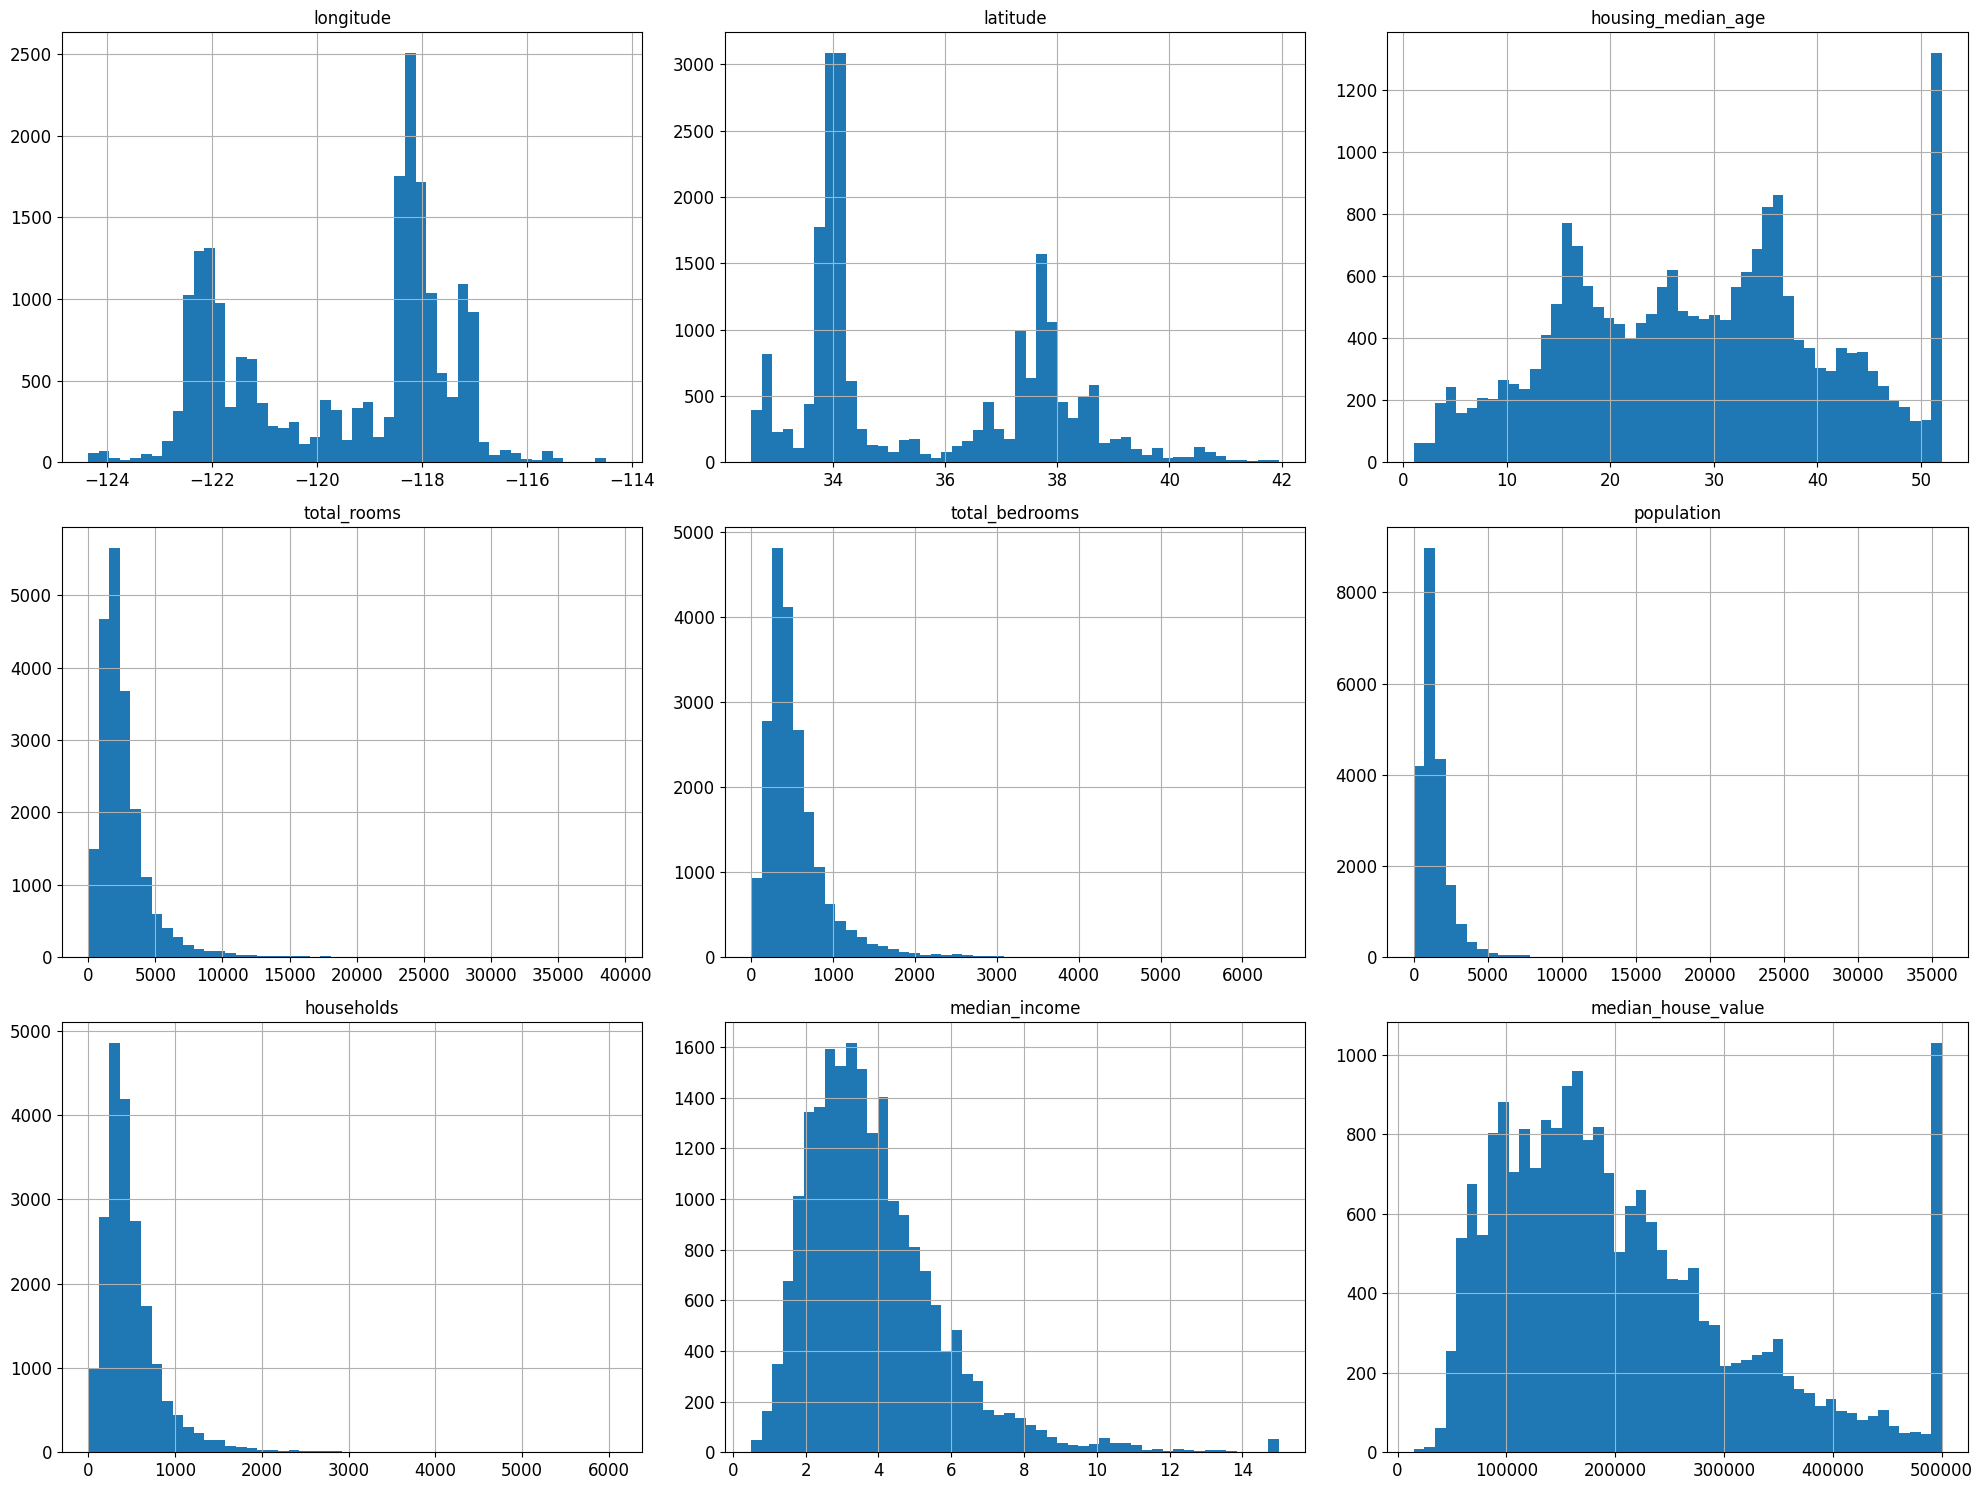

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

## 03_5 División del dataset: Train y Test

In [37]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=1812)

In [38]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
7570,-118.21,33.89,42.0,1254.0,225.0,929.0,235.0,4.3646,116200.0,<1H OCEAN
8790,-118.36,33.80,34.0,2629.0,369.0,966.0,375.0,10.1241,500001.0,NEAR OCEAN
13758,-117.15,34.03,32.0,2832.0,393.0,1033.0,385.0,6.5648,237200.0,INLAND
11332,-117.96,33.75,25.0,1323.0,208.0,852.0,229.0,4.6167,237300.0,<1H OCEAN
6843,-118.13,34.07,20.0,2130.0,654.0,1870.0,578.0,2.3664,192200.0,<1H OCEAN


In [39]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6872,-118.09,34.07,38.0,1036.0,226.0,1058.0,235.0,3.2578,184200.0,<1H OCEAN
17184,-122.49,37.50,21.0,1209.0,309.0,801.0,259.0,4.5625,500000.0,NEAR OCEAN
1461,-121.99,37.97,30.0,3320.0,589.0,1470.0,543.0,4.6071,184100.0,INLAND
1507,-122.05,37.93,15.0,7803.0,1603.0,2957.0,1546.0,4.4500,184900.0,NEAR BAY
17650,-121.88,37.26,25.0,3025.0,689.0,1755.0,661.0,3.8893,218600.0,<1H OCEAN


Podríamos considerar ajustar alguna variable. Por ejemplo, tenemos pocas observaciones por encima de un ingreso medio mayor igual a 6, como se muestra el siguiente gráfico:

<Axes: >

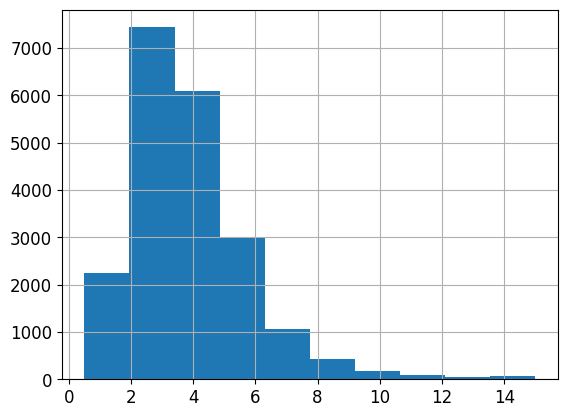

In [40]:
housing["median_income"].hist()

In [41]:
# Categorizamos la columna 'median_income' en cinco grupos de ingresos diferentes para facilitar el análisis:
# Cada rango se etiqueta de 1 a 5 nos permite representar cada categoría de ingreso de forma simplificada.
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [42]:
housing["income_cat"].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

<Axes: >

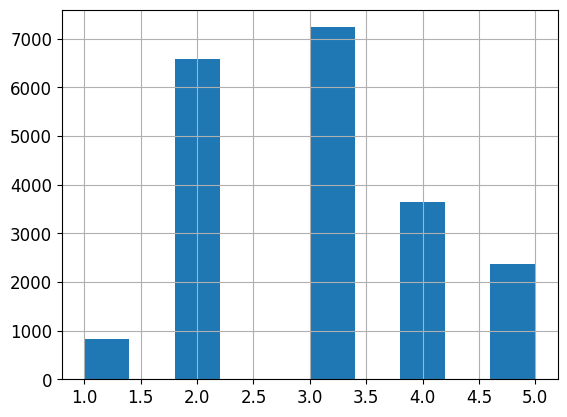

In [43]:
housing["income_cat"].hist()

# 04 Visualización y análisis de los datos

## 04_1 Visualización de datos geográficos

Saving figure bad_visualization_plot


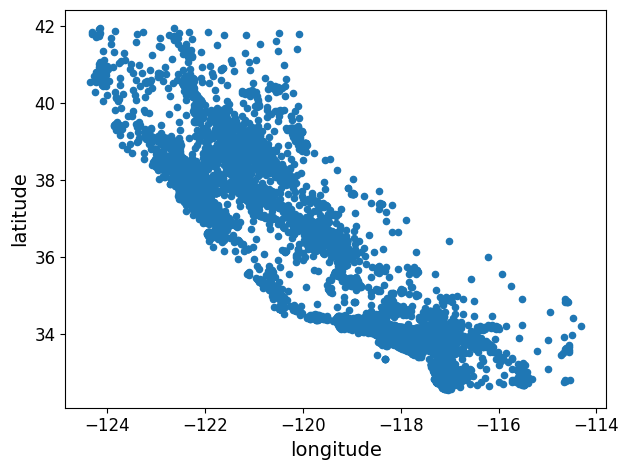

In [44]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure housing_prices_scatterplot


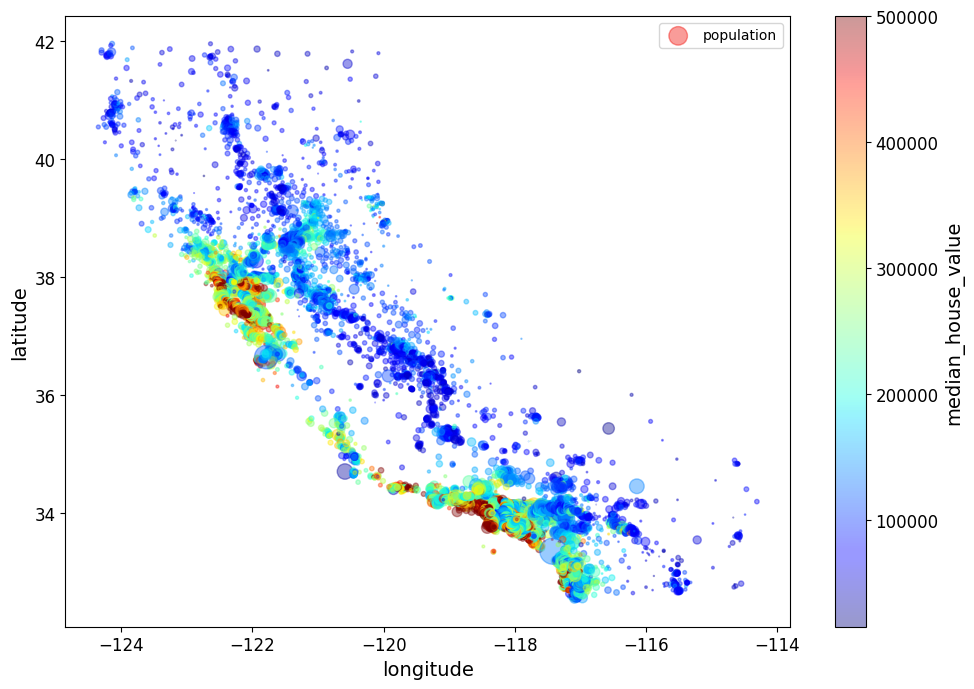

In [45]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

## 04_2 Correlaciones

In [46]:
# Excluimos las columnas no numéricas y calculamos la matriz de correlación.
numeric_housing = housing.select_dtypes(include=[np.number])
corr_matrix = numeric_housing.corr()

In [47]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

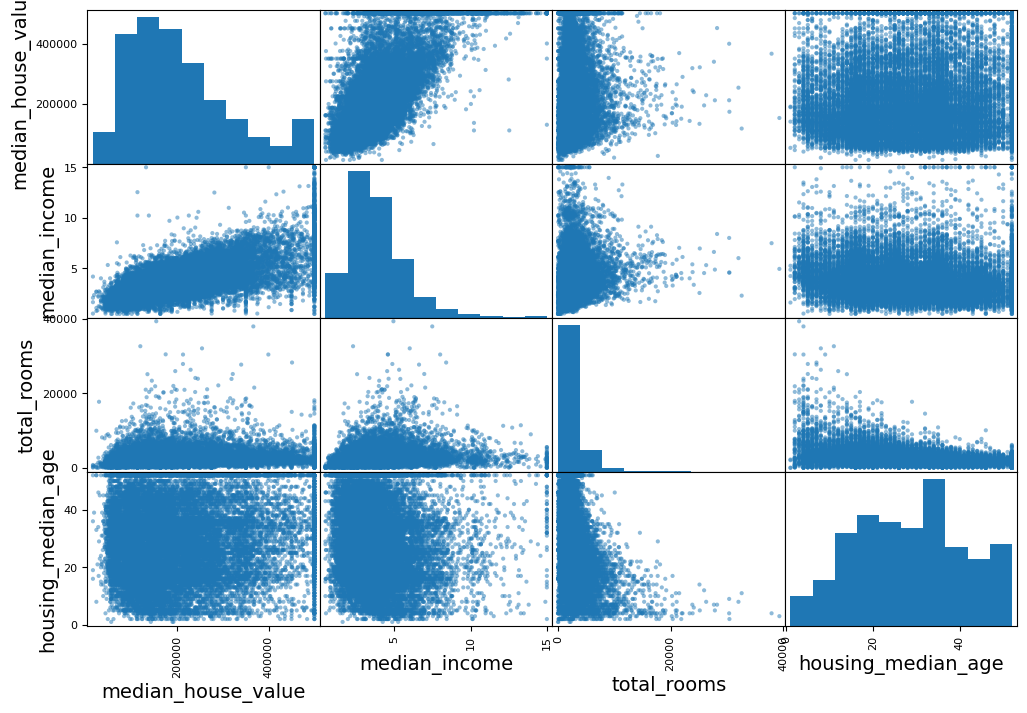

In [51]:
# Definimos una lista de atributos específicos para los cuales queremos visualizar las relaciones entre sí.
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

# Utilizamos la función scatter_matrix para crear una matriz de gráficos de dispersión de los atributos seleccionados.
scatter_matrix(housing[attributes], figsize=(12, 8))

## 04_3 Generación de nuevas variables



In [52]:
# Calculmos las siguientes variables:

# El número de habitaciones por hogar dividiendo el total de habitaciones por el número de hogares.
# Amplitud de los hogares en la zona.
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]

# La cantidad de personas por hogar, que puede ser un indicador de la densidad de ocupación en la zona.
# Características demográficas del área.
housing["population_per_household"]=housing["population"]/housing["households"]

In [53]:
numeric_housing = housing.select_dtypes(include=[np.number])
corr_matrix = numeric_housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
Name: median_house_value, dtype: float64

In [54]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,population_per_household
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,5.429000,3.070655
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,2.474173,10.386050
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.692308
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,4.440716,2.429741
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,5.229129,2.818116
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,6.052381,3.282261
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1243.333333


# 05 Preparación de los datos para los algoritmos de aprendizaje automático

### **05_0 Eliminación de la variable objetivo del subset de entrenamiento**

In [55]:
housing = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"].copy()

### **05_1Limpieza de datos**

Calculamos los valores NaN en cada variable.

In [56]:
# Calcular el porcentaje de NaNs en todas las columnas
percentage_nans = housing.isna().mean() * 100

# Imprimir los resultados
print("Porcentaje de valores NaN por columna:")
print(percentage_nans)

Porcentaje de valores NaN por columna:
longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        1.023498
population            0.000000
households            0.000000
median_income         0.000000
ocean_proximity       0.000000
dtype: float64


Alternativas de limpieza.

In [57]:
# Alternativa 1:
# Eliminamos las filas donde la columna 'total_bedrooms' tiene valores faltantes.
# Esta opción es útil cuando la cantidad de datos faltantes es mínima y no afectará significativamente el conjunto de datos.
#housing.dropna(subset=["total_bedrooms"])

# Alternativa 2:
# Eliminamos la columna 'total_bedrooms' completamente.
# Esta opción puede ser considerada si la columna no es crucial para el análisis posterior o si contiene muchos valores faltantes.
#housing.drop("total_bedrooms", axis=1)

# Alternativa 3:
# Calculamos la mediana de los 'total_bedrooms' y usa este valor para rellenar los datos faltantes en la misma columna.
# Esta es una buena opción para mantener la columna y minimizar el impacto de los valores faltantes, utilizando una medida de tendencia central que no es sensible a los valores atípicos.
#median = housing["total_bedrooms"].median()
#housing["total_bedrooms"].fillna(median, inplace=True)

Para entender cada una de las alternativas, creamos una copia del conjunto de datos pero conservando solo las filas que contienen al menos un valor NaN.

In [58]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
15030,-117.02,32.78,31.0,2567.0,NaN,1198.0,499.0,3.4659,<1H OCEAN
14970,-117.01,32.74,31.0,3473.0,NaN,2098.0,677.0,2.6973,<1H OCEAN
5665,-118.29,33.73,30.0,3161.0,NaN,1865.0,771.0,2.7139,NEAR OCEAN
13597,-117.28,34.09,44.0,376.0,NaN,273.0,107.0,2.2917,INLAND
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,NEAR BAY


alternativa 1 Eliminamos las filas con valores NaN presentes

In [59]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


alternativa 2 Eliminamos columnas específicas

In [60]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
15030,-117.02,32.78,31.0,2567.0,1198.0,499.0,3.4659,<1H OCEAN
14970,-117.01,32.74,31.0,3473.0,2098.0,677.0,2.6973,<1H OCEAN
5665,-118.29,33.73,30.0,3161.0,1865.0,771.0,2.7139,NEAR OCEAN
13597,-117.28,34.09,44.0,376.0,273.0,107.0,2.2917,INLAND
341,-122.17,37.75,38.0,992.0,732.0,259.0,1.6196,NEAR BAY


alternativa 3 Reemplazamos los valores NaN por la mediana

In [61]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)

In [62]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
15030,-117.02,32.78,31.0,2567.0,436.0,1198.0,499.0,3.4659,<1H OCEAN
14970,-117.01,32.74,31.0,3473.0,436.0,2098.0,677.0,2.6973,<1H OCEAN
5665,-118.29,33.73,30.0,3161.0,436.0,1865.0,771.0,2.7139,NEAR OCEAN
13597,-117.28,34.09,44.0,376.0,436.0,273.0,107.0,2.2917,INLAND
341,-122.17,37.75,38.0,992.0,436.0,732.0,259.0,1.6196,NEAR BAY


In [63]:
housing_num = housing.drop("ocean_proximity", axis=1)

La siguiente estrategia se utiliza para rellenar los valores faltantes en las columnas numéricas utilizando la mediana de cada columna.


In [64]:
# Creamos una instancia de SimpleImputer con la estrategia "median".
# No modificamos los datos, solo los calculamos y almacenamos
imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [65]:
imputer.statistics_

array([-118.5    ,   34.26   ,   29.     , 2131.     ,  436.     ,
       1168.     ,  410.     ,    3.54455])

Transformar el conjunto de entrenamiento:

In [66]:
# Aplicamos la imputación aprendida a los datos en housing_num
X = imputer.transform(housing_num)

In [67]:
# Creamos un nuevo DataFrame 'housing_tr'
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
7570,-118.21,33.89,42.0,1254.0,225.0,929.0,235.0,4.3646
8790,-118.36,33.80,34.0,2629.0,369.0,966.0,375.0,10.1241
13758,-117.15,34.03,32.0,2832.0,393.0,1033.0,385.0,6.5648
11332,-117.96,33.75,25.0,1323.0,208.0,852.0,229.0,4.6167
6843,-118.13,34.07,20.0,2130.0,654.0,1870.0,578.0,2.3664


In [68]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
15030,-117.02,32.78,31.0,2567.0,436.0,1198.0,499.0,3.4659
14970,-117.01,32.74,31.0,3473.0,436.0,2098.0,677.0,2.6973
5665,-118.29,33.73,30.0,3161.0,436.0,1865.0,771.0,2.7139
13597,-117.28,34.09,44.0,376.0,436.0,273.0,107.0,2.2917
341,-122.17,37.75,38.0,992.0,436.0,732.0,259.0,1.6196


## 05_2 Tratamiento de Variables de Texto / Categóricas

Preprocesamos la variable ocean_proximity:

In [69]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
7570,<1H OCEAN
8790,NEAR OCEAN
13758,INLAND
11332,<1H OCEAN
6843,<1H OCEAN
13995,INLAND
1270,INLAND
9012,<1H OCEAN
6427,INLAND
13393,INLAND


Crea una instancia de OrdinalEncoder. Esta clase convierte características categóricas en valores enteros ordinales.


In [70]:
# Es útil cuando las características categóricas tienen un orden natural.
ordinal_encoder = OrdinalEncoder()

# Aplicamos el codificador al conjunto de datos categóricos 'housing_cat'.
# Transformamos las categorías textuales en números, lo cual es necesario para modelos de machine learning que
# requieren entradas numéricas.
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [4.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.]])

In [71]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [72]:
# Alternativamente podemos crear un objeto OneHotEncoder y lo aplicamos a housing_cat para convertir categorías texto a un formato numérico binario.
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [73]:
# Convertimos el resultado a un DataFrame para facilitar la visualización
housing_cat_1hot_df = pd.DataFrame(housing_cat_1hot.toarray(), columns=cat_encoder.get_feature_names_out())
print(housing_cat_1hot_df.head(10))

   ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  ocean_proximity_ISLAND  \
0                        1.0                     0.0                     0.0   
1                        0.0                     0.0                     0.0   
2                        0.0                     1.0                     0.0   
3                        1.0                     0.0                     0.0   
4                        1.0                     0.0                     0.0   
5                        0.0                     1.0                     0.0   
6                        0.0                     1.0                     0.0   
7                        1.0                     0.0                     0.0   
8                        0.0                     1.0                     0.0   
9                        0.0                     1.0                     0.0   

   ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN  
0                       0.0                         0.0  
1  

## 05_3 Transformaciones personalizadas (SKIP THIS)

Vamos a crear un transformador personalizado para agregar atributos adicionales:

In [74]:
from sklearn.base import BaseEstimator, TransformerMixin

# Estos son los ínndices de las columnas para un acceso fácil durante las transformaciones.
rooms_ix, population_ix, households_ix = 3, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass  # No se necesitan parámetros de configuración adicionales

    def fit(self, X, y=None):
        return self  # No se realiza ninguna acción más que devolver self

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]  # Calcula habitaciones por hogar
        population_per_household = X[:, population_ix] / X[:, households_ix]  # Calcula población por hogar
        return np.c_[X, rooms_per_household, population_per_household]  # Devuelve los datos originales con las nuevas características añadidas

# Instancia el transformador
attr_adder = CombinedAttributesAdder()

# Aplicamos la transformación para añadir nuevas características basadas en los atributos existentes
housing_extra_attribs = attr_adder.transform(housing.values)

In [75]:
print(housing_extra_attribs[:, :5])

[[-118.21 33.89 42.0 1254.0 225.0]
 [-118.36 33.8 34.0 2629.0 369.0]
 [-117.15 34.03 32.0 2832.0 393.0]
 ...
 [-118.21 33.9 35.0 2420.0 579.0]
 [-118.19 33.78 29.0 1013.0 392.0]
 [-121.81 37.35 28.0 3477.0 671.0]]



Como housing_extra_attribs es una matriz NumPy hemos perdido los nombres de las columnas (desafortunadamente, ese es un problema con Scikit-Learn). Para recuperar un DataFrame, puede ejecutar esto:

In [76]:
# Convertimos el arreglo 'housing_extra_attribs', que contiene las nuevas características calculadas,
# de nuevo en un DataFrame para facilitar el análisis y manipulación de datos.
# Añadimos también las nuevas columnas 'rooms_per_household' y 'population_per_household' al final.
# Usaremos el mismo índice que el DataFrame original.
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns) + ["rooms_per_household", "population_per_household"],
    index=housing.index)

housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
7570,-118.21,33.89,42.0,1254.0,225.0,929.0,235.0,4.3646,<1H OCEAN,5.33617,3.953191
8790,-118.36,33.8,34.0,2629.0,369.0,966.0,375.0,10.1241,NEAR OCEAN,7.010667,2.576
13758,-117.15,34.03,32.0,2832.0,393.0,1033.0,385.0,6.5648,INLAND,7.355844,2.683117
11332,-117.96,33.75,25.0,1323.0,208.0,852.0,229.0,4.6167,<1H OCEAN,5.777293,3.720524
6843,-118.13,34.07,20.0,2130.0,654.0,1870.0,578.0,2.3664,<1H OCEAN,3.685121,3.235294


## 05_4 Pipelines

Un pipeline es una secuencia de transformaciones de datos que facilitan el proceso de codificación.

Construimos un pipeline para preprocesar los atributos numéricos.

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Creamos un pipeline de procesamiento para datos numéricos que incluye varios pasos:
# 1. 'imputer': Imputamos valores faltantes usando la mediana de cada columna.
# 2. 'attribs_adder': Añadimos atributos adicionales combinados.
# 3. 'std_scaler': Escalamos las características para tener media cero y varianza unitaria.
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

# Aplicamos el pipeline a los datos numéricos 'housing_num'.
# El resultado es un conjunto de datos numéricos transformados, listo para ser usado en los algoritmos.
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [78]:
housing_num_tr

array([[ 0.68172215, -0.81918116,  1.06238406, ...,  0.25311475,
        -0.04268226,  0.14414022],
       [ 0.60705417, -0.86127198,  0.42776984, ...,  3.27181888,
         0.59118454, -0.07005586],
       [ 1.20937586, -0.75370656,  0.26911628, ...,  1.40629694,
         0.72184863, -0.05339586],
       ...,
       [ 0.68172215, -0.8145044 ,  0.50709662, ..., -0.94341266,
        -0.36621761,  0.10821732],
       [ 0.69167788, -0.8706255 ,  0.03113595, ..., -1.06810226,
        -0.84915559,  0.06233455],
       [-1.11030935,  0.79897696, -0.04819083, ...,  0.30683768,
        -0.03148858,  0.2469472 ]])

 Se configura un 'ColumnTransformer' para aplicar transformaciones específicas a columnas numéricas y categóricas.
Se aplica el pipeline completo a los datos, preparando el conjunto de datos para modelos de machine learning.

In [79]:
from sklearn.compose import ColumnTransformer

# Listamos los nombres de columnas numéricas y categóricas para su transformación.
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# Configuramos un 'ColumnTransformer' que maneja diferentes tipos de datos (numéricos y categóricos) aplicando
# transformaciones apropiadas a cada tipo.
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),  # Aplica 'num_pipeline' a las columnas numéricas
        ("cat", OneHotEncoder(), cat_attribs),  # Aplica 'OneHotEncoder' a las columnas categóricas
    ])

# Aplicamos el pipeline completo a los datos de 'housing'. Esto incluye imputación, adición de atributos,
# escalado de características numéricas y codificación one-hot de características categóricas.
# El resultado es un conjunto de datos completamente preparado para entrenar los algoritmos.
housing_prepared = full_pipeline.fit_transform(housing)

In [80]:
housing_prepared

array([[ 0.68172215, -0.81918116,  1.06238406, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.60705417, -0.86127198,  0.42776984, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.20937586, -0.75370656,  0.26911628, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.68172215, -0.8145044 ,  0.50709662, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.69167788, -0.8706255 ,  0.03113595, ...,  0.        ,
         0.        ,  1.        ],
       [-1.11030935,  0.79897696, -0.04819083, ...,  0.        ,
         0.        ,  0.        ]])

In [81]:
housing_prepared.shape

(16512, 15)

#06 Seleccionar y Entrenar el Modelo

Entrenamiento y evaluación en el conjunto de entrenamiento

In [82]:
housing_prepared

array([[ 0.68172215, -0.81918116,  1.06238406, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.60705417, -0.86127198,  0.42776984, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.20937586, -0.75370656,  0.26911628, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.68172215, -0.8145044 ,  0.50709662, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.69167788, -0.8706255 ,  0.03113595, ...,  0.        ,
         0.        ,  1.        ],
       [-1.11030935,  0.79897696, -0.04819083, ...,  0.        ,
         0.        ,  0.        ]])

### 06_1 Regresión Lineal

In [83]:

from sklearn.linear_model import LinearRegression

# Creamos una instancia del modelo de Regresión Lineal.
lin_reg = LinearRegression()

# Entrenamos el modelo
# 'housing_prepared' : características de entrada ya procesadas y listas para el modelo,
# 'housing_labels': valores objetivo
lin_reg.fit(housing_prepared, housing_labels)

# Realizamos las predicciones sobre todo el conjunto de datos.
housing_predictions = lin_reg.predict(housing_prepared)

# Calculamos el Mean Squared Error (MSE) comparando las etiquetas reales del conjunto con las predicciones.
lin_mse = mean_squared_error(housing_labels, housing_predictions)

# Calculamos la raíz cuadrada del MSE para obtener el Root Mean Squared Error (RMSE),
# que proporciona una estimación del error en las mismas unidades que la variable de respuesta,
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68450.22143075203

### 06_2 Support Vector Regression (SVR)

In [84]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)

svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111460.9520999863

### 06_3 Red Neuronal

In [85]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Creamos el modelo de red neuronal con múltiples capas y Dropout
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=housing_prepared.shape[1:]))
model.add(Dropout(0.2))  # Desactiva el 20% de las neuronas en esta capa
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  # Desactiva el 20% de las neuronas en esta capa
model.add(Dense(64, activation='relu'))
model.add(Dense(1))  # Capa de salida con una neurona (para regresión)

# Compilamos el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamos el modelo
model.fit(housing_prepared, housing_labels, epochs=50, batch_size=32, validation_split=0.2)

# Realizamos predicciones con el modelo de red neuronal
housing_predictions_nn = model.predict(housing_prepared)

# Calculamos el MSE y el RMSE
nn_mse = mean_squared_error(housing_labels, housing_predictions_nn)
nn_rmse = np.sqrt(nn_mse)
print("Neural Network RMSE:", nn_rmse)

Epoch 1/50
413/413 [==============================] - 2s 3ms/step - loss: 37396369408.0000 - val_loss: 8103185920.0000
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 7080637952.0000 - val_loss: 5061704192.0000
Epoch 3/50
413/413 [==============================] - 2s 5ms/step - loss: 5333154816.0000 - val_loss: 4493421056.0000
Epoch 4/50
413/413 [==============================] - 2s 4ms/step - loss: 4909280768.0000 - val_loss: 4373067264.0000
Epoch 5/50
413/413 [==============================] - 1s 3ms/step - loss: 4761373696.0000 - val_loss: 4312876032.0000
Epoch 6/50
413/413 [==============================] - 1s 3ms/step - loss: 4633325056.0000 - val_loss: 4286334464.0000
Epoch 7/50
413/413 [==============================] - 1s 3ms/step - loss: 4633089536.0000 - val_loss: 4255913472.0000
Epoch 8/50
413/413 [==============================] - 1s 3ms/step - loss: 4563063808.0000 - val_loss: 4226162432.0000
Epoch 9/50
413/413 [==============================] - 1

### 06_4 Árbol de decisión para problema de regresión (DecisionTree)

In [86]:
from sklearn.tree import DecisionTreeRegressor

# Creamos una instancia del modelo de árbol de decisión para regresión.
tree_reg = DecisionTreeRegressor(random_state=1812)

# Entrenamos el modelo del árbol de decisión
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=1812)

In [87]:
# Realizamos predicciones sobre el conjunto de datos de entrenamiento utilizando el modelo de árbol de decisión entrenado.
housing_predictions = tree_reg.predict(housing_prepared)

# Calculamos el Mean Squared Error (MSE) .
tree_mse = mean_squared_error(housing_labels, housing_predictions)

# Calculamos el MSE y el RMSE
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### 06_5 Árbol de decisión para problema de regresión (RandomForest)

In [88]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=1812)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=1812)

In [89]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18511.092526702345

#07 Fine-Tune Your Model

### 07_1 Grid Search

In [90]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=1812)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1812),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

The best hyperparameter combination found:

In [91]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [92]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=1812)

In [93]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

62245.7304422215 {'max_features': 2, 'n_estimators': 3}
55040.39319019913 {'max_features': 2, 'n_estimators': 10}
52074.6740713806 {'max_features': 2, 'n_estimators': 30}
59857.00982810088 {'max_features': 4, 'n_estimators': 3}
52763.99902248032 {'max_features': 4, 'n_estimators': 10}
49760.772753796984 {'max_features': 4, 'n_estimators': 30}
58427.81935034962 {'max_features': 6, 'n_estimators': 3}
51888.047360114615 {'max_features': 6, 'n_estimators': 10}
49675.701887251824 {'max_features': 6, 'n_estimators': 30}
59299.929141320965 {'max_features': 8, 'n_estimators': 3}
52437.124344643904 {'max_features': 8, 'n_estimators': 10}
50077.88874276561 {'max_features': 8, 'n_estimators': 30}
60602.788015362756 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53361.97681100757 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
58253.67348323282 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
51039.48720701171 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [94]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.077713,0.002721,0.004628,0.000070,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.054993e+09,-4.100393e+09,...,-3.874531e+09,1.747138e+08,18,-1.042574e+09,-1.037672e+09,-1.021667e+09,-1.052199e+09,-1.049631e+09,-1.040749e+09,1.083437e+07
1,0.332676,0.120053,0.013205,0.001461,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.079291e+09,-3.203279e+09,...,-3.029445e+09,1.133983e+08,11,-5.576789e+08,-5.655313e+08,-5.483872e+08,-5.681166e+08,-5.742705e+08,-5.627969e+08,8.958244e+06
2,0.817562,0.110007,0.037395,0.004038,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.749807e+09,-2.893099e+09,...,-2.711772e+09,1.118732e+08,7,-4.268674e+08,-4.177989e+08,-4.215009e+08,-4.226410e+08,-4.294611e+08,-4.236539e+08,4.098606e+06
3,0.181399,0.005840,0.005788,0.000329,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.572282e+09,-3.831269e+09,...,-3.582862e+09,1.702625e+08,16,-9.157306e+08,-9.314084e+08,-1.034643e+09,-9.633299e+08,-1.015368e+09,-9.720959e+08,4.624710e+07
4,0.500991,0.092005,0.014156,0.002545,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.858919e+09,-3.010494e+09,...,-2.784040e+09,1.490481e+08,9,-5.112062e+08,-4.932917e+08,-5.254869e+08,-5.198215e+08,-5.429041e+08,-5.185421e+08,1.633874e+07
5,1.228608,0.008060,0.034595,0.000534,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.518154e+09,-2.698136e+09,...,-2.476135e+09,1.358924e+08,2,-3.842175e+08,-3.720148e+08,-3.888249e+08,-3.879642e+08,-3.914285e+08,-3.848900e+08,6.839706e+06
6,0.171039,0.003628,0.004718,0.000078,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.496666e+09,-3.647029e+09,...,-3.413810e+09,1.584149e+08,13,-8.473458e+08,-8.783175e+08,-9.098499e+08,-9.726707e+08,-8.758256e+08,-8.968019e+08,4.278762e+07
7,0.756781,0.120622,0.014382,0.000826,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.666414e+09,-2.950007e+09,...,-2.692369e+09,1.398911e+08,6,-4.805963e+08,-4.834976e+08,-5.091779e+08,-5.133426e+08,-4.935914e+08,-4.960412e+08,1.321967e+07
8,1.730605,0.062294,0.035144,0.002626,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.463636e+09,-2.726182e+09,...,-2.467675e+09,1.425011e+08,1,-3.795067e+08,-3.700945e+08,-3.826117e+08,-3.881493e+08,-3.873901e+08,-3.815505e+08,6.545045e+06
9,0.224015,0.009511,0.004964,0.000411,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.393784e+09,-3.628674e+09,...,-3.516482e+09,1.162050e+08,15,-8.536649e+08,-8.491022e+08,-9.388635e+08,-9.526714e+08,-9.397039e+08,-9.068012e+08,4.553526e+07


### 07_2 Analizar los mejores modelos y sus errores

In [95]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.42805381e-02, 7.14824560e-02, 4.27231498e-02, 2.01046605e-02,
       1.82347089e-02, 1.92241433e-02, 1.76187645e-02, 3.11127422e-01,
       1.04892850e-01, 1.13079342e-01, 8.56490118e-03, 1.79782411e-01,
       2.63510599e-04, 2.47360075e-03, 6.14754004e-03])

In [96]:
# Definimos nombres adicionales para nuevas características derivadas para facilitar la identificación de su importancia.
extra_attribs = ["rooms_per_hhold", "pop_per_hhold"]

# Accedemos al transformador categórico dentro del pipeline completo para obtener los nombres de las categorías después de la codificación one-hot.
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])

# Combinamos las características numéricas, las características adicionales derivadas,
# y características categóricas.
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

# Ordenamos las características por su importancia.
sorted(zip(feature_importances, attributes), reverse=True)

[(0.31112742240143115, 'median_income'),
 (0.1797824112396533, 'INLAND'),
 (0.11307934229407482, 'pop_per_hhold'),
 (0.10489285037270535, 'rooms_per_hhold'),
 (0.08428053814913808, 'longitude'),
 (0.07148245599802344, 'latitude'),
 (0.04272314982908729, 'housing_median_age'),
 (0.02010466052303319, 'total_rooms'),
 (0.01922414328409287, 'population'),
 (0.018234708874144415, 'total_bedrooms'),
 (0.017618764470946114, 'households'),
 (0.008564901177505498, '<1H OCEAN'),
 (0.006147540040288475, 'NEAR OCEAN'),
 (0.0024736007468964213, 'NEAR BAY'),
 (0.0002635105989795884, 'ISLAND')]

### 07_3 Evaluar el modelo en el subset de test

In [97]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [98]:
final_rmse

48548.637189908564

#08 Comparamos Modelos

In [99]:
# Creamos un diccionario con los modelos y sus RMSE correspondientes
rmse_values = {
    "Model": ["Linear Regression", "SVM", "Final Model", "Neural Network"],
    "RMSE": [lin_rmse, svm_rmse, final_rmse, nn_rmse]
}

# Convertimos el diccionario en un DataFrame para una presentación tabular
rmse_table = pd.DataFrame(rmse_values)

# Convertimos la columna RMSE a entero para eliminar los decimales
rmse_table['RMSE'] = rmse_table['RMSE'].astype(int)

# Ordenamos el DataFrame por la columna RMSE de mayor a menor
rmse_table_sorted = rmse_table.sort_values(by='RMSE', ascending=False)
print(rmse_table_sorted)

               Model    RMSE
1                SVM  111460
0  Linear Regression   68450
3     Neural Network   61515
2        Final Model   48548
